In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import array as arr
from numpy import transpose as tr

import ipywidgets as widgets
from IPython.display import display

mpl.rcParams['image.origin']='lower'
mpl.rcParams['image.aspect']='auto'
mpl.rcParams['figure.figsize']=(8,6)
mpl.rcParams['axes.grid']=True


# Définition des classes

In [15]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

class ray:
    def __init__(self, x, y, thetax, thetay, w0, sigma=1, z=0, wl=1030, M2=1):
        '''
        Initialise le rayon à une position sur le miroir 1, avec un angle.
        On lui donne son waist au foyer, et la distance entre ce foyer et le miroir (z).
        /!\ : z=0 signifie que le foyer est sur le miroir ! 
        Le waist donné est celui non-linéaire, qu'on espère avoir en fonctionnement optimal de la cellule.
        '''
        self.x = x
        self.y = y
        self.thetax = thetax
        self.thetay = thetay
        self.wavelength = wl
        self.sigma = sigma
        self.M2 = M2

        # self.q = z + 1j*w0**2 * np.pi/self.wavelength
        self.qnl = z + 1j*w0**2 * np.pi/self.wavelength / np.sqrt(self.sigma)

    def propagation(self, l):
        self.x += l*self.thetax
        self.y += l*self.thetay
        # self.q += l
        self.qnl += l
    
    def mirror(self, Roc):
        self.thetax -= 2*self.x/Roc
        self.thetay -= 2*self.y/Roc
        # self.q = self.q/(1-2/Roc*self.q)
        self.qnl = self.qnl/(1-2/Roc*self.qnl)

    def translate_to_polar(self):
        return cart2pol(self.x, self.y)

    def waist0(self):
        return(np.sqrt(np.imag(self.qnl)/np.pi*self.wavelength*np.sqrt(self.sigma))* np.sqrt(self.M2))

    def waist(self):
        return(1/np.sqrt(np.imag(-1/self.qnl) *np.pi/np.sqrt(self.sigma)/self.wavelength)* np.sqrt(self.M2))

class cavity:
    def __init__(self, L, RCmirror, Rmirror, reflectivity=1, pressure=1, n0=1, n2=0, d=1, NL=0):
        self.length = L
        self.radius = Rmirror
        self.roc = RCmirror
        self.pressure = pressure
        self.n0 = n0
        self.n2 = n2
        self.distance_to_window = d
        self.reflectivity = reflectivity
        self.NL = 1.0*NL


    def injection_laser(self, x_in, y_in, thetax_in, thetay_in, E, wl, w0, tau0, z=0, M2=1):
        self.x_in = x_in
        self.y_in = y_in
        self.thetax_in = thetax_in
        self.thetay_in = thetay_in

        self.beam_wavelength = wl
        self.beam_energy = E
        self.beam_waist_size = w0
        self.beam_focus_pos = z
        self.tau0 = tau0
        self.beam_M2 = M2

        self.tau_eff = tau0 * np.sqrt(np.pi/(np.log(8)))
        self.power = self.beam_energy / self.tau0
        self.Peff = self.beam_energy / self.tau_eff
        self.Pcrit = 3.77*self.beam_wavelength**2/(8*np.pi*self.pressure*self.n2)
        self.sigma = 1 - self.power/self.Pcrit /np.sqrt(2) * self.NL
        self.Bint = 0
        self.BintViotti = 0
        self.b = 0

        if self.sigma <= 0:
            print('The peak power is over the critical power. \n Look at what you did wrong')
 
    def optimize_waist(self):
        self.beam_waist_size = np.sqrt(self.beam_wavelength*self.length/(2*np.pi)*np.sqrt(self.sigma*(2*self.roc/self.length-1)))
        return(self.beam_waist_size)

    def waists(self, show=True):
        Ray_test = ray(self.x_in, self.y_in, self.thetax_in, self.thetay_in, sigma=self.sigma, wl=self.beam_wavelength, z=self.beam_focus_pos, w0=self.beam_waist_size, M2 = self.beam_M2)
        
        waist_mirror = Ray_test.waist()
        Fl = 2*self.beam_energy / (waist_mirror**2 * np.pi)

        if show:
            print(f'Waist on mirrors = {waist_mirror*1e6:.1f}µm')
            Ray_test.propagation(-self.length/2)
            print(f'Waist at focus = {Ray_test.waist()*1e6:.1f}µm')
            Ray_test.propagation(-self.distance_to_window)
            print(f'Waist on window = {Ray_test.waist()*1e6:.1f}µm')
            Ray_test.sigma = 1
            Ray_test.propagation(+self.distance_to_window)
            print(f'Waist for alignment = {Ray_test.waist()*1e6:.1f}µm')
            print(f'Fluence on mirrors = {Fl*1e-4} J/cm^2')
            print('-----')

        else:
            return(waist_mirror, Fl)


    def propag_MPC(self, N):
        self.Ray = ray(self.x_in, self.y_in, self.thetax_in, self.thetay_in, sigma=self.sigma, wl=self.beam_wavelength, z=self.beam_focus_pos, w0=self.beam_waist_size, M2=self.beam_M2)
        energy = self.beam_energy
        self.Bint = 0
        self.BintViotti = 0

        self.Ray.propagation(-self.length)
        self.xentry = self.Ray.x
        self.yentry = self.Ray.y
        self.waist_entry = self.Ray.waist()
        
        self.Bint += self.B_integral(energy=energy)
        self.BintViotti += self.B_integral(energy=energy, Viotti=True)
        
        self.Ray = ray(self.x_in, self.y_in, self.thetax_in, self.thetay_in, sigma=self.sigma, wl=self.beam_wavelength, z=self.beam_focus_pos, w0=self.beam_waist_size, M2=self.beam_M2)
        self.Ray.mirror(self.roc)
        l_Rcell = []
        l_Rmirror = [self.Ray.translate_to_polar()[0]]
        l_phimirror = [self.Ray.translate_to_polar()[1]]
        l_waist_mirror = []
        l_Bint = []
        
        
        for i in range(N):

            l_waist_mirror.append(self.Ray.waist())
            self.Ray.propagation(self.length/2)     #Propagate to the middle of the cell
            l_Rcell.append(self.Ray.translate_to_polar()[0])
            self.Bint += self.B_integral(energy=energy)
            l_Bint.append(self.B_integral(energy=energy))
            self.BintViotti += self.B_integral(energy=energy, Viotti=True)

            self.Ray.propagation(self.length/2)
            r, phi = self.Ray.translate_to_polar()
            self.Ray.mirror(self.roc)
            l_Rmirror.append(r)
            l_phimirror.append(phi)
            energy *= self.reflectivity
            sigma_i = 1 - energy/self.tau0 / self.Pcrit / np.sqrt(2)
            self.Ray.sigma = sigma_i
        

        self.b = 7*np.pi**2 * self.n2 * self.pressure * self.power * N / (2 * self.beam_wavelength**2)
        return(arr(l_Rmirror), arr(l_phimirror), arr(l_waist_mirror), arr(l_Bint))

    def B_integral(self, energy, Viotti=0):
        if not Viotti:
            return 4*np.pi*self.n2*self.pressure/self.beam_wavelength**2 * energy/self.tau0 /np.sqrt(self.sigma*self.beam_M2) * np.arctan(np.sqrt(self.length/(2*self.roc-self.length)))
        else:
            return 2*np.pi**2 * self.n2 * self.pressure * energy/self.tau0 / self.beam_wavelength**2 #* np.arccos(1-self.length/self.roc)
    def optimize_angle(self, N, axis=0, mode='sum'):
        
        tab_incr = [1, 0.1, 0.01, 0.01]
        startVal = 0
        R_in = np.sqrt(self.x_in**2+self.y_in**2)
        for j in range(len(tab_incr)):
            incr = tab_incr[j]

            t = []
            tab_angles = np.linspace(startVal-incr, startVal+incr, 100)
            for i in range(len(tab_angles)):
                if axis==0:
                    self.thetax_in = tab_angles[i]
                elif axis==1:
                    self.thetay_in = tab_angles[i]
                l_Rmirror, *_ = self.propag_MPC(N)
                if mode=='sum':
                    t.append(np.sum(l_Rmirror))
                elif mode=='var':
                    t.append(np.sum(np.var(l_Rmirror-R_in)))

            i1 = np.argmin(t)
            startVal = tab_angles[i1]
        if axis==0:
            self.thetax_in = tab_angles[i1]
        elif axis==1:
            self.thetay_in = tab_angles[i1]

    def optimize_injection(self, N):
        self.optimize_angle(N, 0, 'sum')
        self.optimize_angle(N, 1, 'var')
        self.optimize_angle(N, 0, 'var')



Waist on mirrors = 2559.1µm
Waist at focus = 128.0µm
Waist on window = 2565.5µm
Waist for alignment = 128.0µm
Fluence on mirrors = 68.04627612142616 J/cm^2
Waist for bis = 128.0µm
-----
0.002559097897033539
0.002559097897033539
0.002559097897033539


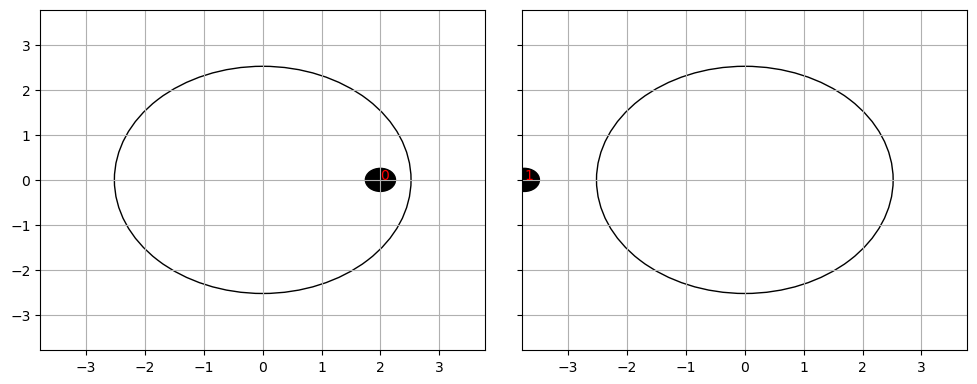

In [34]:
#Test cavité Hanna
n2 = 0.97e-23 #argon

L = 1.995
N = 3
Rmirror = 2.52e-3
Cavity = cavity(L=L, RCmirror=1, Rmirror=Rmirror, reflectivity=1, pressure=1, n2=n2, NL=1, d=1)
Cavity.injection_laser(2, 0, 0, 0, wl=1030e-9, E=7, w0=165, tau0=450, z=0.5*L, M2=1)
Cavity.optimize_waist()

Cavity.waists()
l_Rs, l_thetas, l_waists, _ = Cavity.propag_MPC(N)


Cavity.Ray



# Paramètres et affichage

In [16]:
# %matplotlib ipympl
if 1:
    Rmirror = 25.7  #En mm

    slider_N =          widgets.IntSlider(min=1, max=50, step=1, value=25, continuous_update=False)
    slider_x =          widgets.FloatSlider(min=-Rmirror, max=Rmirror, step=0.1, value=20, continuous_update=False)
    slider_y =          widgets.FloatSlider(min=-Rmirror, max=Rmirror, step=0.1, value=0.0, continuous_update=False)
    slider_thetax =     widgets.FloatSlider(min=-50, max=50, step=0.1, value=0, continuous_update=False)
    slider_thetay =     widgets.FloatSlider(min=-50, max=50, step=0.1, value=0, continuous_update=False)


    # slider_energy =     widgets.FloatSlider(min=0, max=10, step=0.1, value=4, continuous_update=False)
    slider_tau =        widgets.FloatSlider(min=100, max=1000, step=10, value=450, continuous_update=False)
    slider_pressure =   widgets.FloatSlider(min=0, max=5, step=0.1, value=1, continuous_update=False)
    # slider_roc =        widgets.FloatSlider(min=0.1, max=2, step=0.01, value=0.75, continuous_update=False)
    slider_waist =      widgets.FloatSlider(min=50, max=1000, step=1, value=165, continuous_update=False)


    slider_energy =     widgets.BoundedFloatText(min=0, max=10, step=0.1, value=4)
    slider_tau =        widgets.BoundedFloatText(min=100, max=1000, step=10, value=450)
    slider_roc =        widgets.BoundedFloatText(min=0.1, max=2, step=0.01, value=0.75)
    slider_rmirror =    widgets.BoundedFloatText(min=12, max=100, step=0.1, value=25.4)
    slider_dwindow =    widgets.BoundedFloatText(min=0, max=5, step=0.1, value=1.0)

    slider_M2 = widgets.BoundedFloatText(min=1, max=2, step=0.1, value=1.2)

    checkbox_angle =    widgets.Checkbox(value=True)
    checkbox_waist =    widgets.Checkbox(value=True)
    checkbox_NL =       widgets.Checkbox(value=False)

    # slider_L =          widgets.FloatSlider(min=0, max=2*slider_roc.value-0.001, step=0.001, value=1.481, continuous_update=False)
    slider_L =          widgets.BoundedFloatText(min=0, max=2*slider_roc.value-0.001, step=0.001, value=1.481)

    def update_L_range(*args):
        slider_L.max = 2*slider_roc.value-0.001
    slider_roc.observe(update_L_range, 'value')


    def MPC(N=slider_N, L=slider_L, x=slider_x, y=slider_y, thetax=slider_thetax, thetay=slider_thetay,
            RCmirror=slider_roc, Rmirror=slider_rmirror, pressure=slider_pressure, optimize_angle=True, dwindow=slider_dwindow, 
            optimize_waist=True, w0=slider_waist, E=slider_energy, tau0=slider_tau, M2=slider_M2, NL=checkbox_NL):

        out_waists.clear_output(wait=False)
        out_mirrors.clear_output(wait=False)
        out_pulse.clear_output(wait=False)
        out_addgraphs.clear_output(wait=False)
        n2 = 0.97e-23 #argon

        zf = 0.5    #position du foyer dans la cavité : 0.5 = foyer au milieu
        refl = 0.995

        #Conversion of the sliders in SI units
        E *= 1e-3
        w0 *= 1e-6
        tau0 *= 1e-15
        x *= 1e-3
        y *= 1e-3
        thetax *= 1e-3
        thetay *= 1e-3
        Rmirror *= 1e-3

        wl = 1030e-9
        # P = E/tau0
        # Pcrit = 3.77*wl**2/(8*np.pi*pressure*n2)
        # sigma = 1-P/Pcrit/np.sqrt(2)

        # with out1:
        #     print(f'Peak power = {P*1e-9} GW')
        #     print(f'Pcrit = {Pcrit*1e-9} GW')
        #     print(f'Sigma = {sigma}')
        Cavity = cavity(L=L, RCmirror=RCmirror, Rmirror=Rmirror, reflectivity=refl, pressure=pressure, n2=n2, NL=NL, d=dwindow)
        Cavity.injection_laser(x, y, thetax, thetay, wl=wl, E=E, w0=w0, tau0=tau0, z=zf*L, M2=M2)
        if optimize_waist:
            slider_waist.value = 1e6 * Cavity.optimize_waist()

        with out_waists:
            Cavity.waists()

        if optimize_angle:
            Cavity.optimize_angle(N, 0, 'sum')
            Cavity.optimize_angle(N, 1, 'var')
            Cavity.optimize_angle(N, 0, 'var')
            slider_thetax.value = Cavity.thetax_in *1e3
            slider_thetay.value = Cavity.thetay_in *1e3
        

        l_Rs, l_thetas, l_waists, l_Bints = Cavity.propag_MPC(N)


        with out_mirrors:
            f, (ax_M1, ax_M2) = plt.subplots(1,2, figsize=(10,4), sharey=True)
            f.tight_layout()
            taxes = [ax_M1, ax_M2]
            for ax in taxes:
                ax.set_xlim([-Rmirror*1.5e3,Rmirror*1.5e3])
                ax.set_ylim([-Rmirror*1.5e3,Rmirror*1.5e3])
                ax.add_artist(plt.Circle((0,0),Rmirror*1e3, fill=False))
            ax_M2.add_artist(plt.Circle([Cavity.xentry*1e3, Cavity.yentry*1e3], Cavity.waist_entry*3e3, color='g'))
            for i in range(N):
                x, y = pol2cart(l_Rs[i], l_thetas[i])
                taxes[i%2].add_artist(plt.Circle([x*1e3, y*1e3], l_waists[i]*3e3, color='k'))
                taxes[i%2].annotate(str(i), xy= (x*1e3, y*1e3), c='r')
            plt.show()

        with out_pulse:
            print(f'Integrale B par rebond (/pi) : {Cavity.Bint/N/np.pi:.2f}')
            print(f'Integrale B totale (/pi) : {Cavity.Bint/np.pi:.2f}')
            print(f'Ratio de compression pour {N} rebonds : {Cavity.Bint/np.pi:.2f}')
            print(f'tau_in = {tau0*1e15:.2f} fs')
            print(f'tau_out_B = {tau0*1e15/(Cavity.Bint/np.pi):.2f} fs')
            print('_____________________')
            print(f'Integrale BViotti par rebond (/pi): {Cavity.BintViotti/np.pi/N:.2f}')
            print(f'Integrale BViotti totale (/pi): {Cavity.BintViotti/np.pi:.2f}')
            print(f'Ratio de compression Viotti pour {N} rebonds : {Cavity.BintViotti/np.pi:.2f}')
            print(f'tau_out_Bviotti = {tau0*1e15/(Cavity.BintViotti/np.pi):.2f} fs')
            print(f'Elargissement spectral pour {N} rebonds : {Cavity.b/np.pi:.2f}')
            print(f'tau_out_b = {tau0*1e15/(Cavity.b/np.pi):.2f} fs')
            print('_____________________')
            print(f'Energy input = {E*1e3}mJ')
            print(f'Energy output = {Cavity.beam_energy *1e3}mJ')
            print('-----')


        with out_addgraphs:
            Jd = 0.2 *1e4
            Iin = 1e14 *1e4

            R = np.linspace(0, 10, 100)

            lim_dam = 2*R*E**2 / (E**2 + wl**2*R**2*Jd**2)
            lim_ion_l = R - np.sqrt(R**2 - E**2*16 / (wl**2*tau0**2*Iin**2), where=[R**2 > E**2*16 / (wl**2*tau0**2*Iin**2)][0])
            lim_ion_h = R + np.sqrt(R**2 - E**2*16 / (wl**2*tau0**2*Iin**2), where=[R**2 > E**2*16 / (wl**2*tau0**2*Iin**2)][0])

            f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,4))
            ax1.plot(R, 2*R, '--k')
            ax1.plot(R, lim_dam, 'b')
            ax1.plot(R, lim_ion_l, 'r')
            ax1.plot(R, lim_ion_h, 'g')
            ax1.scatter(RCmirror, L, marker='x', color='r')
            ax1.set_xlim((0,RCmirror*1.5))
            ax1.set_ylim((0,RCmirror*3))
            plot_waist = ax2.plot(range(N), l_waists*1e3, 'ob')
            ax2b = ax2.twinx()
            plot_Bint = ax2b.plot(range(N), l_Bints/np.pi, 'or')
            ax2b.grid(False)
            ax1.set_xlabel('Radius of curvature')
            ax1.set_ylabel('Length')
            ax2.set_xlabel('N rebonds')
            ax2.set_ylabel('Waist on mirrors (mm)')
            # ax2b.set_ylabel('B integral')
            ax2.legend(plot_waist+plot_Bint , ['Waist (mm)', 'B_integral (pi)'])

            ax3.plot(range(0, N+1, 2), l_thetas[::2], '-ob')
            ax3.plot(range(1, N+1, 2), l_thetas[1::2], '-or')
            ax3.set_xlabel('N rebonds')
            ax3.legend(['mirror 1', 'mirror 2'])
            plt.show()


    out_waists      = widgets.Output(layout={'border': '1px solid black'})
    out_mirrors     = widgets.Output(layout={'border': '1px solid black'})
    out_pulse       = widgets.Output(layout={'border': '1px solid black'})
    out_addgraphs   = widgets.Output(layout={'border': '1px solid black'})

    def several_outputs(N, L, x, y, thetax, thetay, RCmirror, Rmirror, pressure, M2, dwindow, optimize_angle,  optimize_waist, w0, E, tau0, NL):
        out_waists.clear_output(wait=False)
        out_mirrors.clear_output(wait=False)
        out_pulse.clear_output(wait=False)
        out_addgraphs.clear_output(wait=False)

        MPC(**{'N':N, 'L':L, 'x':x, 'y':y, 'thetax':thetax, 'thetay':thetay,
                                            'pressure':pressure, 'RCmirror':RCmirror, 'Rmirror':Rmirror, 'optimize_angle':optimize_angle, 'dwindow':dwindow,
                                            'E':E, 'tau0':tau0, 'w0':w0, 'M2':M2, 'optimize_waist':optimize_waist, 'NL':NL})


    out = widgets.interactive_output(MPC, {'N':slider_N, 'L':slider_L, 'x':slider_x, 'y':slider_y, 'thetax':slider_thetax, 'thetay':slider_thetay,
                                            'pressure':slider_pressure, 'RCmirror':slider_roc, 'Rmirror':slider_rmirror, 'optimize_angle':checkbox_angle, 'dwindow':slider_dwindow,
                                            'E':slider_energy, 'tau0':slider_tau, 'w0':slider_waist, 'M2':slider_M2, 'optimize_waist':checkbox_waist, 'NL':checkbox_NL})


    titles = [
        'Energy (mJ)', 'tau_in (fs)', 'RoC (m)', 'Radius (mm)', 'N', 'L (m)', 'Waist (µm)', 'Pressure (bar)', 'x (mm)', 'y (mm)', 'thetax (mrad)', 'thetay (mrad)', 
        'M2', 'd to window', 'Optimize angle', 'Optimal waist', 'NL_propag'
    ]

    Param_names = widgets.VBox([widgets.Label(title) for title in titles])

    Params = widgets.VBox([
        slider_energy, slider_tau, slider_roc, slider_rmirror, slider_N, slider_L, slider_waist, slider_pressure, slider_x, slider_y, slider_thetax, slider_thetay,
        slider_M2, slider_dwindow, checkbox_angle, checkbox_waist, checkbox_NL
    ])

    ui = widgets.HBox([Param_names, Params, out_mirrors])

    display(ui)
    display(out_waists   )
    display(out_pulse    )
    # display(out_addgraphs)



Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

## Optimisation complète

In [10]:
E = 4e-3
tau0 = 450e-15
wl = 1030e-9
M2 = 1.2
zf = 0.5



R = 0.75
Jd = 0.2 *1e4
pressure = 1
n2 = 0.97e-23 #argon
Rmirror = 25.4e-3   ##diamètre 2 pouces

sigma = 1 - (E/tau0)/(3.77*wl**2/(8*np.pi*pressure*n2))

Lmin = 2*2*R*E**2 / (2*E**2 + wl**2*R**2*Jd**2) 
Lmax = 1.999*R
dL = 0.005

lL = np.arange(Lmin, Lmax, dL)
lK = []
lwm = []
lfl = []
l_dthetas = []


tau_cible = 30e-15
B_int_est = np.pi * tau0/tau_cible

N = int(B_int_est / (4*np.pi*n2/wl**2 * E/tau0 /np.sqrt(sigma*M2) * np.pi/2)) + 1
# N = 30
print(f'For {tau0*1e15}fs to {tau_cible*1e15}fs, we estimate {N} bounces')

for iL in range(len(lL)):
    L = lL[iL]


    Cavity = cavity(L=L, RCmirror=R, Rmirror=Rmirror, pressure=pressure, n2=n2)
    Cavity.injection_laser(x_in=20e-3, y_in=0, thetax_in=0, thetay_in=0, E=E, wl=wl, w0=200e-6, tau0=tau0, z=zf*L, M2=M2)
    w0 = Cavity.optimize_waist()
    Cavity.optimize_injection(N)

    waist_mirror, fluence = Cavity.waists(show=False)
    _, l_thetas, _, _ = Cavity.propag_MPC(N)
    K = Cavity.Bint / np.pi
    lK.append(K)
    lwm.append(waist_mirror)
    lfl.append(fluence)
    l_thetas_ordered = np.sort(l_thetas)
    l_dthetas.append(np.min(arr([l_thetas_ordered[i]-l_thetas_ordered[i-2] for i in range(2, len(l_thetas))])))

lK = arr(lK)
lwm = arr(lwm)
lfl = arr(lfl)
l_dthetas = arr(l_dthetas)




For 450.0fs to 30.0fs, we estimate 22 bounces


In [11]:


i = (-l_dthetas).argmin()
i = 20
L_opt = lL[i]
print(i, L_opt)

slider_L_grossier = widgets.FloatSlider(min=int(lL[0]*100)/100, max=int(lL[-1]*100)/100, value=L_opt, step=0.01, continuous_update=False)
slider_L_fin = widgets.FloatSlider(min=0, max=100, value=0, step=1, continuous_update=False)


def plot_L(L_grossier, L_fin):
    L_opt = L_grossier+L_fin*0.0001
    print(L_opt)
    f, axes = plt.subplots(1,3, figsize=(20,4))
    ax_tau = axes[0]
    ax_fluence = axes[1]
    ax_dtheta = axes[2]
    ax_tau.plot(lL, tau0/lK*1e15, 'ob')
    ax_fluence.plot(lL, lfl*1e-4, 'ob')
    ax_fluence.axhline(y=Jd*1e-4, color='r')
    ax_dtheta.plot(lL, l_dthetas, 'ob')
    # ax_tau.plot(lL[i], tau0/lK[i]*1e15, 'og')
    # ax_fluence.plot(lL[i], lfl[i]*1e-4, 'og')
    # ax_dtheta.plot(lL[i], l_dthetas[i], 'og')
    ax_dtheta.axhline(y=4*np.pi / (N+1), color='r')
    ax_tau.axvline(x=L_opt, color='g')
    ax_fluence.axvline(x=L_opt, color='g')
    ax_dtheta.axvline(x=L_opt, color='g')

    Cavity = cavity(L=L_opt, RCmirror=R, Rmirror=Rmirror, pressure=pressure, n2=n2)
    Cavity.injection_laser(x_in=20e-3, y_in=0, thetax_in=0, thetay_in=0, E=E, wl=wl, w0=200e-6, tau0=tau0, z=zf*L, M2=M2)
    w0 = Cavity.optimize_waist()
    Cavity.optimize_injection(N)
    l_Rs, l_thetas, l_waists, l_Bints = Cavity.propag_MPC(N)

    f, (ax_M1, ax_M2) = plt.subplots(1,2, figsize=(10,4), sharey=True)
    f.tight_layout()
    taxes = [ax_M1, ax_M2]
    for ax in taxes:
        ax.set_xlim([-Rmirror*1.5e3,Rmirror*1.5e3])
        ax.set_ylim([-Rmirror*1.5e3,Rmirror*1.5e3])
        ax.add_artist(plt.Circle((0,0),Rmirror*1e3, fill=False))
    ax_M2.add_artist(plt.Circle([Cavity.xentry*1e3, Cavity.yentry*1e3], Cavity.waist_entry*3e3, color='g'))
    for i in range(N):
        x, y = pol2cart(l_Rs[i], l_thetas[i])
        taxes[i%2].add_artist(plt.Circle([x*1e3, y*1e3], l_waists[i]*3e3, color='k'))
        taxes[i%2].annotate(str(i), xy= (x*1e3, y*1e3), c='r')



ui = widgets.VBox([slider_L_grossier, slider_L_fin])


out = widgets.interactive_output(plot_L, {'L_grossier':slider_L_grossier, 'L_fin':slider_L_fin})
display(ui, out)

20 1.4958753337923223


Output()

# Old code

In [ ]:
##OLD CODE

# %matplotlib ipympl
if 1:
    Rmirror = 25.7  #En mm

    slider_N =          widgets.IntSlider(min=1, max=50, step=1, value=25, continuous_update=False)
    slider_x =          widgets.FloatSlider(min=-Rmirror, max=Rmirror, step=0.1, value=20, continuous_update=False)
    slider_y =          widgets.FloatSlider(min=-Rmirror, max=Rmirror, step=0.1, value=0.0, continuous_update=False)
    slider_thetax =     widgets.FloatSlider(min=-50, max=50, step=0.1, value=0, continuous_update=False)
    slider_thetay =     widgets.FloatSlider(min=-50, max=50, step=0.1, value=0, continuous_update=False)
    checkbox_angle =    widgets.Checkbox(value=True)


    # slider_energy =     widgets.FloatSlider(min=0, max=10, step=0.1, value=4, continuous_update=False)
    slider_tau =        widgets.FloatSlider(min=100, max=1000, step=10, value=450, continuous_update=False)
    slider_pressure =   widgets.FloatSlider(min=0, max=5, step=0.1, value=1, continuous_update=False)
    slider_rmirror =    widgets.FloatSlider(min=12, max=100, step=0.1, value=25.4, continuous_update=False)
    # slider_roc =        widgets.FloatSlider(min=0.1, max=2, step=0.01, value=0.75, continuous_update=False)
    slider_waist =      widgets.FloatSlider(min=50, max=1000, step=1, value=165, continuous_update=False)
    checkbox_waist =    widgets.Checkbox(value=True)


    slider_energy =     widgets.BoundedFloatText(min=0, max=10, step=0.1, value=4)
    slider_roc =        widgets.BoundedFloatText(min=0.1, max=2, step=0.01, value=0.75)

    slider_M2 = widgets.BoundedFloatText(min=1, max=2, step=0.1, value=1.2)
    checkbox_NL = widgets.FloatSlider(value=False)

    slider_L =          widgets.FloatSlider(min=0, max=2*slider_roc.value-0.001, step=0.001, value=1.481, continuous_update=False)

    def update_L_range(*args):
        slider_L.max = 2*slider_roc.value-0.001
    slider_roc.observe(update_L_range, 'value')


    def MPC(N=slider_N, L=slider_L, x=slider_x, y=slider_y, thetax=slider_thetax, thetay=slider_thetay,
            RCmirror=slider_roc, Rmirror=slider_rmirror, pressure=slider_pressure, optimize_angle=True, 
            optimize_waist=True, w0=slider_waist, E=slider_energy, tau0=slider_tau):

        M2 = 1.2
        n2 = 0.97e-23 #argon

        zf = 0.5    #position du foyer dans la cavité : 0.5 = foyer au milieu
        refl = 0.995

        #Conversion of the sliders in SI units
        E *= 1e-3
        w0 *= 1e-6
        tau0 *= 1e-15
        x *= 1e-3
        y *= 1e-3
        thetax *= 1e-3
        thetay *= 1e-3
        Rmirror *= 1e-3

        wl = 1030e-9
        P = E/tau0
        Pcrit = 3.77*wl**2/(8*np.pi*pressure*n2)
        sigma = 1-P/Pcrit/np.sqrt(2)
        print(f'Peak power = {P*1e-9} GW')
        print(f'Pcrit = {Pcrit*1e-9} GW')
        print(f'Sigma = {sigma}')
        Cavity = cavity(L=L, RCmirror=RCmirror, Rmirror=Rmirror, reflectivity=refl, pressure=pressure, n2=n2, sc=3)
        Cavity.injection_laser(x, y, thetax, thetay, wl=wl, E=E, w0=w0, tau0=tau0, z=zf*L, M2=M2)
        if optimize_waist:
            slider_waist.value = 1e6 * Cavity.optimize_waist()
        Cavity.waists()

        if optimize_angle:
            Cavity.optimize_angle(N, 0, 'sum')
            Cavity.optimize_angle(N, 1, 'var')
            Cavity.optimize_angle(N, 0, 'var')
            slider_thetax.value = Cavity.thetax_in *1e3
            slider_thetay.value = Cavity.thetay_in *1e3
        

        l_Rs, l_thetas, l_waists, l_Bints = Cavity.propag_MPC(N, show=False)

        _, (ax_M1, ax_M2) = plt.subplots(1,2, figsize=(12,5))

        taxes = [ax_M1, ax_M2]
        for ax in taxes:
            ax.set_xlim([-Rmirror*1.5e3,Rmirror*1.5e3])
            ax.set_ylim([-Rmirror*1.5e3,Rmirror*1.5e3])
            ax.add_artist(plt.Circle((0,0),Rmirror*1e3, fill=False))
        ax_M2.add_artist(plt.Circle([Cavity.xentry*1e3, Cavity.yentry*1e3], Cavity.waist_entry*3e3, color='g'))
        for i in range(N):
            x, y = pol2cart(l_Rs[i], l_thetas[i])
            taxes[i%2].add_artist(plt.Circle([x*1e3, y*1e3], l_waists[i]*3e3, color='k'))
            taxes[i%2].annotate(str(i), xy= (x*1e3, y*1e3), c='r')

        print('_____________________')
        print(f'Integrale B par rebond (/pi) : {Cavity.Bint/N/np.pi:.2f}')
        print(f'Integrale B totale (/pi) : {Cavity.Bint/np.pi:.2f}')
        print(f'Ratio de compression pour {N} rebonds : {Cavity.Bint/np.pi:.2f}')
        print(f'tau_in = {tau0*1e15:.2f} fs')
        print(f'tau_out_B = {tau0*1e15/(Cavity.Bint/np.pi):.2f} fs')
        print('_____________________')
        print(f'Integrale BViotti par rebond (/pi): {Cavity.BintViotti/np.pi/N:.2f}')
        print(f'Integrale BViotti totale (/pi): {Cavity.BintViotti/np.pi:.2f}')
        print(f'Ratio de compression Viotti pour {N} rebonds : {Cavity.BintViotti/np.pi:.2f}')
        print(f'tau_out_Bviotti = {tau0*1e15/(Cavity.BintViotti/np.pi):.2f} fs')
        print(f'Elargissement spectral pour {N} rebonds : {Cavity.b/np.pi:.2f}')
        print(f'tau_out_b = {tau0*1e15/(Cavity.b/np.pi):.2f} fs')
        print('_____________________')
        print(f'Energy input = {E*1e3}mJ')
        print(f'Energy output = {Cavity.beam_energy *1e3}mJ')


        if 1:
            Jd = 0.2 *1e4
            Iin = 1e14 *1e4

            R = np.linspace(0, 10, 100)

            lim_dam = 2*R*E**2 / (E**2 + wl**2*R**2*Jd**2)
            lim_ion_l = R - np.sqrt(R**2 - E**2*16 / (wl**2*tau0**2*Iin**2), where=[R**2 > E**2*16 / (wl**2*tau0**2*Iin**2)][0])
            lim_ion_h = R + np.sqrt(R**2 - E**2*16 / (wl**2*tau0**2*Iin**2), where=[R**2 > E**2*16 / (wl**2*tau0**2*Iin**2)][0])

            f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,4))
            ax1.plot(R, 2*R, '--k')
            ax1.plot(R, lim_dam, 'b')
            ax1.plot(R, lim_ion_l, 'r')
            ax1.plot(R, lim_ion_h, 'g')
            ax1.scatter(RCmirror, L, marker='x', color='r')
            ax1.set_xlim((0,RCmirror*1.5))
            ax1.set_ylim((0,RCmirror*3))
            plot_waist = ax2.plot(range(N), l_waists*1e3, 'ob')
            ax2b = ax2.twinx()
            plot_Bint = ax2b.plot(range(N), l_Bints/np.pi, 'or')
            ax2b.grid(False)
            ax1.set_xlabel('Radius of curvature')
            ax1.set_ylabel('Length')
            ax2.set_xlabel('N rebonds')
            ax2.set_ylabel('Waist on mirrors (mm)')
            # ax2b.set_ylabel('B integral')
            ax2.legend(plot_waist+plot_Bint , ['Waist (mm)', 'B_integral (pi)'])

            ax3.plot(range(0, N+1, 2), l_thetas[::2], '-ob')
            ax3.plot(range(1, N+1, 2), l_thetas[1::2], '-or')
            ax3.set_xlabel('N rebonds')
            ax3.legend(['mirror 1', 'mirror 2'])

    output1 = widgets.Output()
    output2 = widgets.Output()
    out = widgets.interactive_output(MPC, {'N':slider_N, 'L':slider_L, 'x':slider_x, 'y':slider_y, 'thetax':slider_thetax, 'thetay':slider_thetay,
                                            'pressure':slider_pressure, 'RCmirror':slider_roc, 'Rmirror':slider_rmirror, 'optimize_angle':checkbox_angle,
                                            'E':slider_energy, 'tau0':slider_tau, 'w0':slider_waist, 'optimize_waist':checkbox_waist})

    moving_params = widgets.VBox([slider_N, slider_L, slider_x, slider_y, slider_thetax, slider_thetay, checkbox_angle])
    titles = ['N', 'L (m)', 'x (mm)', 'y (mm)', 'thetax (mrad)', 'thetay (mrad)', 'Optimize angle', 'M2']
    moving_params_names = widgets.VBox([widgets.Label(title) for title in titles])
    stable_params = widgets.VBox([slider_energy, slider_tau, slider_roc, slider_rmirror, slider_pressure, slider_waist, checkbox_waist])
    titles = ['Energy (mJ)', 'tau (fs)', 'RoC (m)', 'Radius (mm)', 'Pressure (bar)', 'Waist (µm)', 'Optimal waist', 'NL_propag']
    stable_params_names = widgets.VBox([widgets.Label(title) for title in titles])
    ui = widgets.HBox([moving_params_names, moving_params, stable_params_names, stable_params])

    stable_params = widgets.VBox([])

    out.layout.height = '1300px'
    out.clear_output(wait=True)
    display(ui)
    display(out)
    # output
